In [1]:
# © Saeed Khan, Fangjun Hu, Princeton University, 2023

from qiskit import IBMQ, Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit_ibm_runtime.options import EnvironmentOptions, ExecutionOptions, TranspilationOptions
from qiskit.quantum_info import SuperOp
from qiskit.quantum_info import partial_trace
from qiskit.result import marginal_counts
from qiskit.result import QuasiDistribution

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

import torch
from torchvision import transforms
import torchvision.datasets as datasets
from torch.autograd import Variable

from sklearn import linear_model

# QiskitRuntimeService.save_account(channel="ibm_quantum", token='10ced88f63398589a7355e8512f8c7444c16dd99e2c76e8f026cdfdca60c2d6822b08d51eb5b3ee3a786a5ce3e7753bcead52e7e0b9d5321d22cef132acbacf2')
# IBMQ.save_account(token='10ced88f63398589a7355e8512f8c7444c16dd99e2c76e8f026cdfdca60c2d6822b08d51eb5b3ee3a786a5ce3e7753bcead52e7e0b9d5321d22cef132acbacf2')
IBMQ.save_account(token='10ced88f63398589a7355e8512f8c7444c16dd99e2c76e8f026cdfdca60c2d6822b08d51eb5b3ee3a786a5ce3e7753bcead52e7e0b9d5321d22cef132acbacf2', overwrite=True)

import json
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
import os

# Auxiliary functions: *Do not* import auxMNIST when running CE task
from auxCE import *

C:\Users\wewil\AppData\Local\Temp\ipykernel_25056\1473229208.py:27: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(token='10ced88f63398589a7355e8512f8c7444c16dd99e2c76e8f026cdfdca60c2d6822b08d51eb5b3ee3a786a5ce3e7753bcead52e7e0b9d5321d22cef132acbacf2', overwrite=True)
C:\Users\wewil\AppData\Local\Temp\ipykernel_25056\1473229208.py:27: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit

Navigation: <a id='top' />

<a href=#run>Ansatz definitions (run this first)</a> 

<a href=#Load>Load IBMQ data for multiple runs and save histograms</a> 

<a href=#CA>CA Plot</a> 

<a href=#CALoss>IBM Qiskit results with larger losses</a> 

<a href=#CADelay>IBMQ results with delays</a> 

#### Ansatz definitions (run all cells here first) <a id='run' />

<a href=#top>Return to top</a>

In [2]:
# Ansatz parameters

# Number of qubits
NQ = 7

# Number of readout qubits
NR = 4
# NR = 7

# Readout qubit indices
if NR == 4:
    NRIdx = [0,2,4,6]
if NR == 7:
    NRIdx = [0,1,2,3,4,5,6]

# Boolean variable, = 1 if reset is applied
reset = 1

# Number of layers
# NL = 1
# NL = 2
# NL = 5 
# NL = 8
# NL = 10
NL = 20
# NL = 50
# NL = 100

# Number of repeated blocks
# NT = 2
NT = 3

# Mean Rx, Rz gate angles
thetaX = 1.0
thetaZ = 0.5
thetaI = 0.1
    
# Coupling
J = 1.0

# Random-ness parameter
sigmaX = 1.0
sigmaZ = 0.5
sigmaI = 0.1

# Circuit ansatz number
circNum = 'T' + str(1)

# Circuit ansatz
cpname = 'lin'
coupling_map = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6]] 

# Number of coupling terms
NC = len(coupling_map)

# Number of shots
# NS = int(1e3)
# NS = int(1e4)
NS = int(1e5)

# Number of readout features per layer
K = 2**NR

# Circuit seed
circSeed = 17462

# Decay parameters (microseconds)
T1m = 103e3
T1v = 10e3
T2m = 170e3
T2v = 10e3

# Define ansatz dictionary
ansatz = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': reset, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# ansatz = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': reset, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map}
print('Ansatz: ')
print(ansatz)

Ansatz: 
{'NQ': 7, 'NR': 4, 'NRIdx': [0, 2, 4, 6], 'reset': 1, 'NL': 20, 'NT': 3, 'thetaX': 1.0, 'thetaZ': 0.5, 'thetaI': 0.1, 'J': 1.0, 'sigmaX': 1.0, 'sigmaZ': 0.5, 'sigmaI': 0.1, 'NS': 100000, 'cp': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]], 'T1m': 103000.0, 'T2m': 170000.0, 'T1v': 10000.0, 'T2v': 10000.0}


In [ ]:
# Run ansatz defining function, return circuit ansatz and indices of classical registers
# circT, CRIdx, simulator = ansatzT1(ansatz)
circT, CRIdx, simulator, noise_model = ansatzT1_4(ansatz)

C:\Users\wewil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


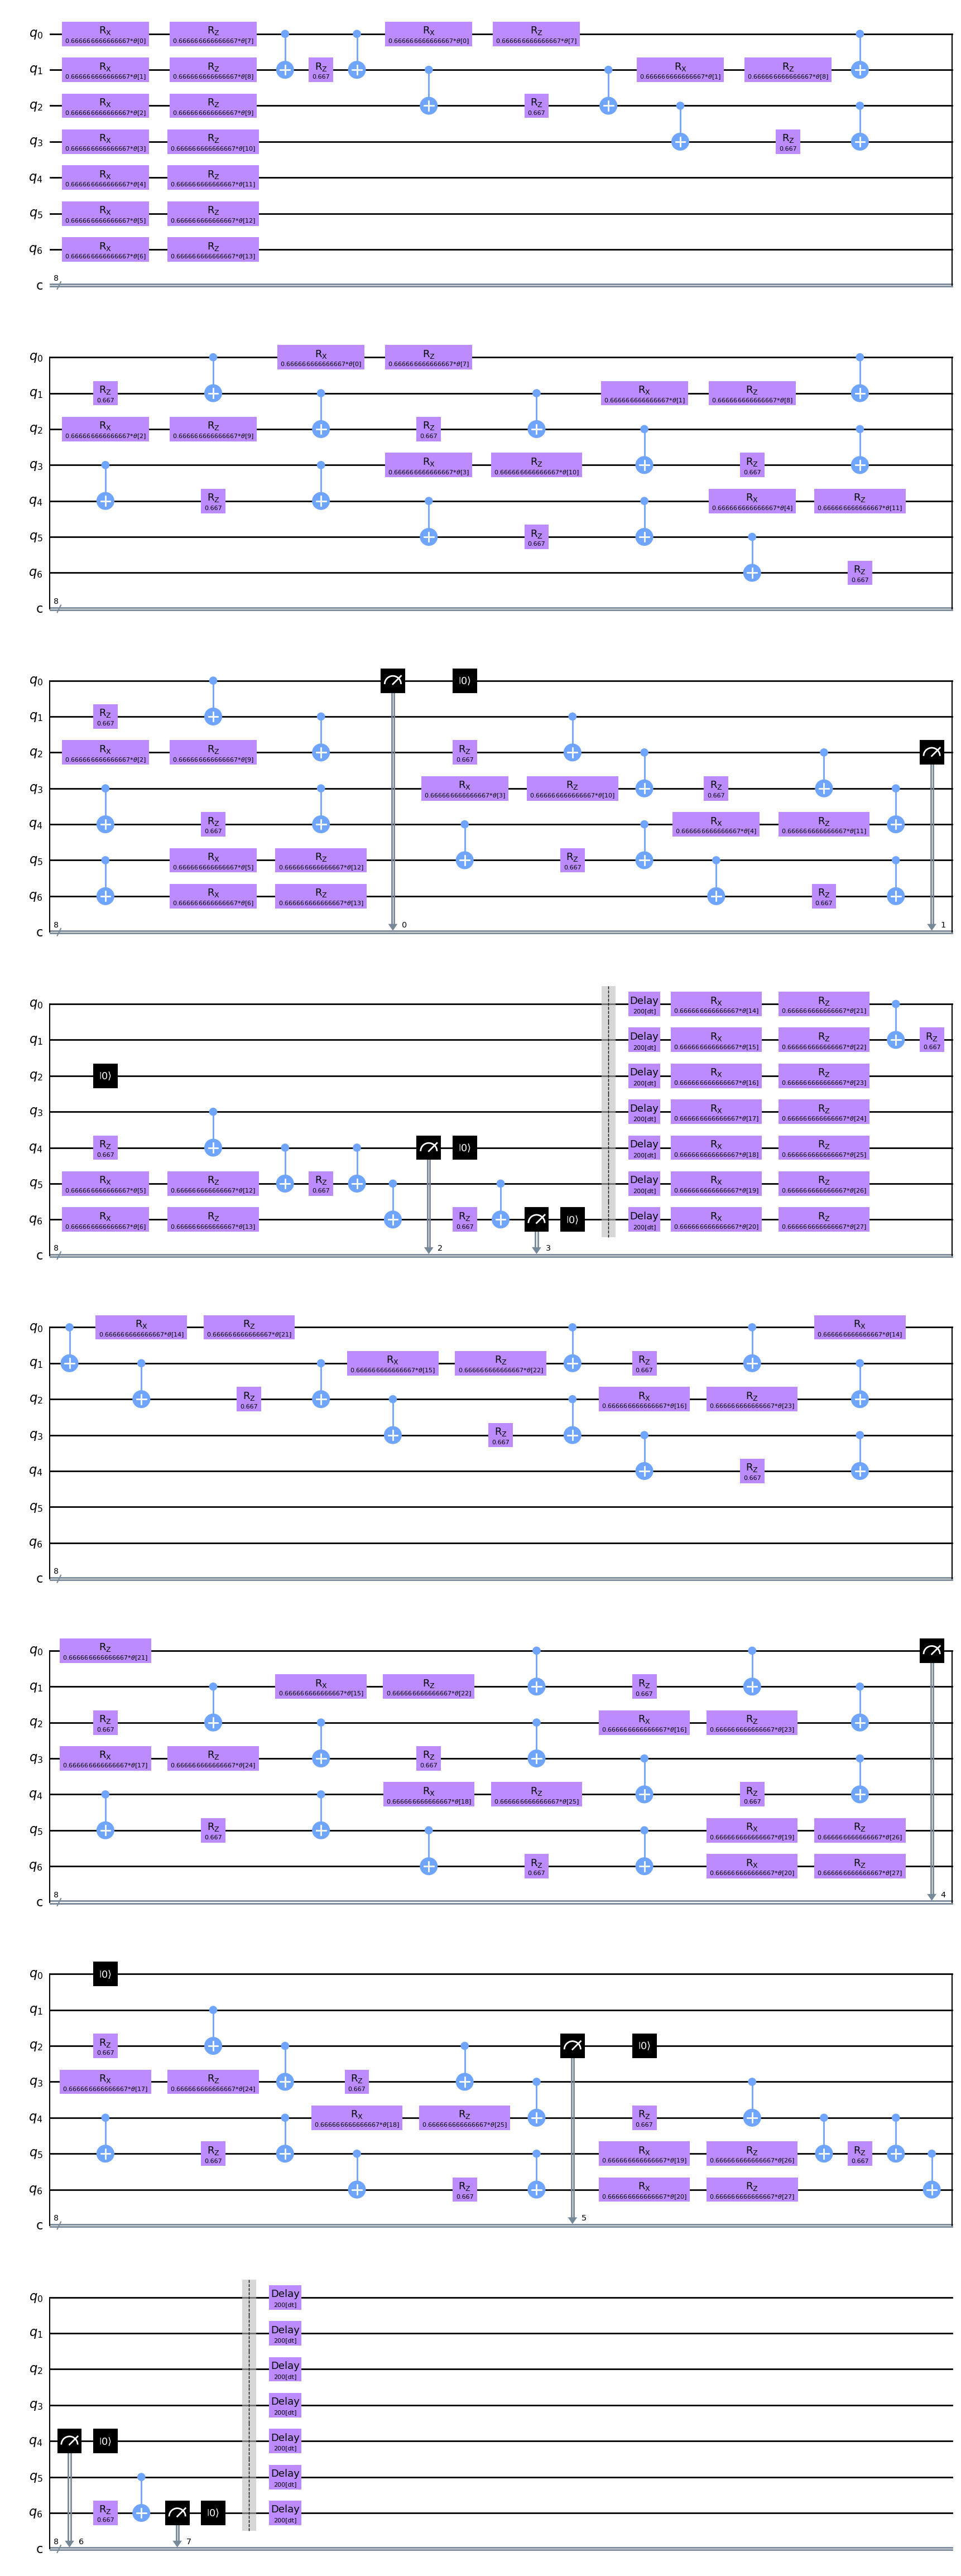

In [ ]:
# Draw circuit (only reasonable if NL is small)
circT.draw('mpl')

#### Generate input data

In [3]:
# Message symbols
symb = [-3,-1,+1,+3]

# Number of messages
M = 100
# M = 1

# SNR
SNR = 20.0

# Convolution kernel: channel coefficients
cc = [1.0, 0.18, -0.1, +0.091, -0.05, +0.04, +0.03, +0.01]
ccn = len(cc) 

# Storage matrix
symbMat = np.zeros((M,NL))
inputMat = np.zeros((M,NL))

# Loop over messages to be generated
for m in range(M):
    
    # Seed RNGs and generate CE input message
    np.random.seed(m)

    # Loop over time indices
    for nl in range(NL):
        
        # Find random integer for CE task symbols
        ii = np.random.randint(low=0,high=len(symb))
        symbMat[m,nl] = symb[ii]
        
    # Convolve
    symbVec = symbMat[m,:]
    f1 = np.convolve(cc, np.concatenate((symbVec[-ccn::],symbVec)), mode = 'full')[ccn:-ccn+1]
    
    # Nonlinear distortion and addition of white noise
    inputMat[m,:] = f1 + 1*(0.06*f1**2 - 0.01*f1**3) + np.sqrt(10.0**(-SNR/10.0))*np.random.randn(NL)
    
print('Generated data!')

Generated data!


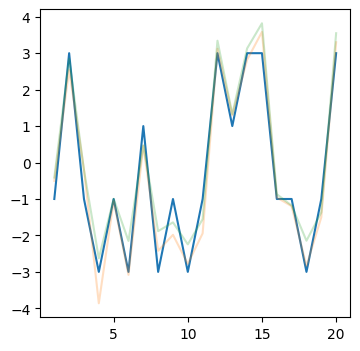

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

# Example of CE task message (here the last one, m=-1)
m = -1
ax.plot(np.arange(1,NL+1,1), symbMat[m,:])
ax.plot(np.arange(1,NL+1,1), f1, alpha=0.25)
ax.plot(np.arange(1,NL+1,1), inputMat[m,:], alpha=0.25)

plt.show()

In [5]:
# Number of dataset permutations
# P = 1
# P = 10
P = 20

# Training and testing for each number of shots per permutation
classMatInTRP = np.zeros((P))
classMatInTEP = np.zeros((P))  

# Initialize random number generator
np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    if p > 0:
        np.random.shuffle( randSort )
    
    # Data matrix for this permutation
    dataMatInR = np.copy(inputMat)
    dataMatIn = dataMatInR[randSort,:]
    
    # Sort symbols
    symbMatR = np.copy( symbMat )
    symbMatRR = symbMatR[randSort,:]

    # Compile training and testing sets
    train_data = np.transpose(dataMatIn[0:50,:], axes=[0,1]) # For LR on Qiskit output
    test_data = np.transpose(dataMatIn[50:,:], axes=[0,1]) # For LR on Qiskit output
    MessageSetSymb_train = symbMatRR[0:50,:]
    MessageSetSymb_test = symbMatRR[50:,:]
        
    # train_data = inputMat[0:50,:] # For LR on data directly
    Output_Feature = train_data
    N_train = 50
    N_test = 50
    Nsymb = NL
#     N_of = K

    Output_Feature_train = Output_Feature
    Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on Qiskit output
    # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
    MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

    Output_Feature_test = test_data
    Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, 1)) # For LR on Qiskit output
    MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

    # Initialize logistic regression model
    # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
    lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

    # Train model and then test using training set
    # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
    lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
    CAIn = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

    # Testing on testing set
    CAInTest = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    #     print('IBM Device CE error for NS: ' + str(NSTot))
    classMatInTRP[p] = CAIn
    classMatInTEP[p] = CAInTest

# Mean CA over permutations
classMatInTR = np.mean(classMatInTRP,axis=0)
classMatInTE = np.mean(classMatInTEP,axis=0)

eT = time.time()
print('Calculated CA on input data! Elapsed time: ' + str(eT-sT))

Calculated CA on input data! Elapsed time: 0.40082216262817383


In [6]:
classMatInTR, classMatInTE 

(0.04845000000000004, 0.05340000000000004)

#### Encode generated data into circuit parameters

In [ ]:
# Storage matrix for all parameters
paramMat = np.zeros((M,2*NQ*NL))

# Loop over messages
for m in range(M):
        
    # Set current input vector
    inputVec = inputMat[m,:]
    
    # Return encoded parameters
    paramVec = circT1(inputVec, ansatz, seed=circSeed)
    
    # Store parameters
    paramMat[m,:] = np.copy(paramVec)
    
print('Encoded parameters!')

Encoded parameters!


In [ ]:
np.shape(paramMat)

(100, 280)

#### Load IBMQ data

In [ ]:
# exp_str = 'exper-T-01' 
exp_str = 'exper-T-02'
# run_str = 'run06' # NL = 8, S = 1e5
# run_str = 'run01' # NL = 20, S = 2.5e4
run_str = 'run01' # NL = 20, S = 2.5e4

fPre = '/scratch/gpfs/saeedk/IBMQiskitRuntime/'

# jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
# jbase = f"ce-{exp_str}-{run_str}-ibm_auckland"
jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
with open(f'{fPre}CEData/{exp_str}/{jbase}-job_info.json', 'r') as handle:
    job_info = json.load(handle)
    
# Extract quasidists
fileName = f'{fPre}CEData/{exp_str}/{jbase}-qdists.pickle'
with open(fileName, 'rb') as handle:
    test = pickle.load(handle)
    
# Convert to QuasiDistribution object
quasi_dists = []
[quasi_dists.append(QuasiDistribution(qd)) for qd in test]
    
print('Loaded data!')

Loaded data!


In [ ]:
# Compile dataset

# Dictionary of bitstrings
bitstring_dict = []
calcString('', bitstring_dict, NR)

# Data matrix
dataMatIBM = np.zeros((M,K,NL))

# Iterate over messages
sT = time.time()
for m in range(M):
    
    # Iterate over layers
    for nl in range(NL):
        
        # Define indices of readout qubits for this layer
#         indNR = list(np.arange(nl*NR,(nl+1)*NR,1))
        indNR = list(np.arange(nl*NR,(nl+1)*NR,1)[::-1]) # Reversed indices
#         indNR = list(np.arange( (NL-nl-1)*NR,(NL-nl)*NR,1)[::-1]) # Reversed layers and indices
        
        # Extract marginal counts
        counts = marginal_counts(quasi_dists[m].binary_probabilities(), indices=indNR )
        
        # Convert to frequencies/probabilities
        for k in range(K):
            try:
                dataMatIBM[m,k,nl] = counts[bitstring_dict[k]]
            except KeyError:
                # If bitstring not found, set probability to zero
                dataMatIBM[m,k,nl] = 0.0
        
eT = time.time()
print('Extracted counts! Elapsed time: ' + str(eT-sT))

Extracted counts! Elapsed time: 141.50334358215332


In [ ]:
# Perform classification
train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
# train_data = inputMat[0:50,:] # For LR on data directly
Output_Feature = train_data
N_train = 50
Nsymb = NL
N_of = K

Output_Feature_train = Output_Feature
MessageSetSymb_train = symbMat[0:50,:]
Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
# Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

# Run LR
# lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)

# Testing
# lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

print('IBM Device CE error for NS: ' + str(NS))
print(CAIBM)

IBM Device CE error for NS: 100000
0.03200000000000003


In [ ]:
# Qiskit accuracy, noise-free and including noise

### Load IBMQ data for multiple runs and save histograms<a id='Load' />

<a href=#top>Return to top</a>

In [ ]:
# Dictionary of bitstrings
bitstring_dict = []
calcString('', bitstring_dict, NR)

# Vector of runs
runVec = ['run01']
# runVec = ['run02']
# runVec = ['run01','run02']
# runVec = ['run01','run02','run03','run04']
# runVec = ['run01','run02','run03','run04','run05']
# runVec = ['run01','run02','run03','run04','run05','run06','run07','run08']
# runVec = ['run01','run02','run03','run04','run05','run06','run07','run08','run09']
# runVec = ['run01','run02','run03','run04','run05','run06','run07','run08','run09','run10']
# runVec = ['run01','run02','run03','run04','run05','run06','run07','run08','run09','run10','run11']
# runVec = ['run01','run02','run03','run04','run05','run06','run07']

# File name information
fPre = 'DellaBackup/scratch/gpfs/saeedk/IBMQiskitRuntime/'
fPreSave = 'DellaBackup/scratch/gpfs/saeedk/IBMQiskitRuntimeHistograms/'
# exp_str = 'exper-T-02'
# exp_str = 'exper-T-03'
# exp_str = 'exper-T-04's
# exp_str = 'exper-T-05'
exp_str = 'exper-T-02-ext'
    
# Compile dataset

# Counter for total number of shots
NSTot = 0

# Complete data matrix
# dataMatIBM = np.zeros((M,K,NL,len(runVec)))
dataMatIBM = np.zeros((M,K,NL))
dataMatIBMRun = np.zeros((M,K,NL,len(runVec)))
classMatTR = np.zeros((len(runVec)))
classMatTE = np.zeros((len(runVec)))

# Iterate over messages
sT = time.time()

# Loop over datasets
for nr in range(len(runVec)):
    
    # Run string
    run_str = runVec[nr]
    
    # Load file
    jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
    with open(str('D:\\') + os.path.normpath(f'{fPre}CEData/{exp_str}/{jbase}-job_info.json'), 'r') as handle:
        job_info = json.load(handle)

    # Extract quasidists
    fileName = f'{fPre}CEData/{exp_str}/{jbase}-qdists.pickle'
    fileNameSave = f'{fPreSave}CEData/{exp_str}/{jbase}-hists'
    with open(str('D:\\') + os.path.normpath(fileName), 'rb') as handle:
        test = pickle.load(handle)
        
    # Convert to QuasiDistribution object
    quasi_dists = []
    [quasi_dists.append(QuasiDistribution(qd)) for qd in test]
    # quasi_dists_new = []
    # for m in range(M):
    #     for nrr in range(5):
    #         # quasi_dists_new.append(QuasiDistribution(dict(list(test[m].items())[nrr*50000:(nrr+1)*50000])))
    #         quasi_dists_new.append(QuasiDistribution(dict(list(test[m].items())[nrr*50000:(nrr+1)*50000])))
    
    # Number of shots for this run
#     NS = int( job_info['total shots'] )
    
    # Loop over messages
    for m in range(M):

        # Iterate over layers
        for nl in range(NL):

            # Define indices of readout qubits for this layer
    #         indNR = list(np.arange(nl*NR,(nl+1)*NR,1))
            indNR = list(np.arange(nl*NR,(nl+1)*NR,1)[::-1]) # Reversed indices
    #         indNR = list(np.arange( (NL-nl-1)*NR,(NL-nl)*NR,1)[::-1]) # Reversed layers and indices

            # Extract marginal counts
            counts = marginal_counts(quasi_dists[m].binary_probabilities(), indices=indNR )
            # counts_new = marginal_counts(dict(list(quasi_dists[m].items())[nr*50000:(nr+1)*50000]).binary_probabilities(), indices=indNR )
            # counts_new = marginal_counts(quasi_dists_new[m].binary_probabilities(), indices=indNR )

            # Convert to frequencies/probabilities
            checkCt = 0
            for k in range(K):
                try:
                    checkCt = checkCt + counts[bitstring_dict[k]]
                    dataMatIBM[m,k,nl] = dataMatIBM[m,k,nl] + counts[bitstring_dict[k]]
                    dataMatIBMRun[m,k,nl,nr] = counts[bitstring_dict[k]]
                except KeyError:
                    # If bitstring not found, set probability to zero
                    checkCt = checkCt + 0
                    dataMatIBM[m,k,nl] = dataMatIBM[m,k,nl] + 0.0
                    dataMatIBMRun[m,k,nl,nr] = 0.0
                    
    # Number of shots actually returned
    NS = int( checkCt )
    
    # Add to total number of shots
    NSTot = NSTot + NS
                    
    # Save histogram of counts for this run if not previously save
    if os.path.exists(str('D:\\') +  os.path.normpath(fileNameSave +' _NS_' + str(NS) + '.npy') ) == False:
        np.save(str('D:\\') + os.path.normpath(fileNameSave + '_NS_' + str(NS) + '.npy'), dataMatIBMRun[:,:,:,nr])
        
    # Normalize by dividing by number of shots
    print(NS, NSTot)
    dataMatIBM = dataMatIBM/NSTot

    # Compile training and testing sets
    train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
    test_data = np.transpose(dataMatIBM[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
    # train_data = inputMat[0:50,:] # For LR on data directly
    Output_Feature = train_data
    N_train = 50
    N_test = 50
    Nsymb = NL
    N_of = K
    
    Output_Feature_train = Output_Feature
    MessageSetSymb_train = symbMat[0:50,:]
    Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
    # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
    MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))
    
    Output_Feature_test = test_data
    MessageSetSymb_test = symbMat[50:,:]
    Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
    MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

    # Initialize logistic regression model
    # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
    lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)

    # Train model and then test using training set
    # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
    lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
    CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
    
    # Testing on testing set
    CAIBMTest = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
    
#     print('IBM Device CE error for NS: ' + str(NSTot))
    classMatTR[nr] = CAIBM
    classMatTE[nr] = CAIBMTest
    # print(CAIBM)
    
    # Rescale counts
    dataMatIBM = dataMatIBM*NSTot

eT = time.time()
print('Extracted counts! Elapsed time: ' + str(eT-sT))

250000 250000
Extracted counts! Elapsed time: 1582.2291059494019


In [ ]:
classMatTR, classMatTE

(array([0.032]), array([0.048]))

In [ ]:
testMat = np.copy(dataMatIBM)

In [ ]:
# Perform classification
train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
# train_data = inputMat[0:50,:] # For LR on data directly
Output_Feature = train_data
N_train = 50
Nsymb = NL
N_of = K

Output_Feature_train = Output_Feature
MessageSetSymb_train = symbMat[0:50,:]
Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
# Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

# Run LR
# lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)

# Testing
# lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

print('IBM Device CE error for NS: ' + str(NS))
print(CAIBM)

IBM Device CE error for NS: 240000
0.03700000000000003


C:\Users\wewil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


#### Separate large number of shots into smaller sections

In [29]:
# Dictionary of bitstrings
bitstring_dict = []
calcString('', bitstring_dict, NR)

# Run string
# run_str = 'run01' # 20 us original qubits
# run_str = 'run02' # 20 us new qubits
# run_str = 'run03' # 40 us original qubits
# run_str = 'run04' # 10 us original qubits 
# run_str = 'run08' # More shots, 40 us original qubits
run_str = 'run09' # More shots, 20 us original qubits

# File name information
fPre = 'DellaBackup/scratch/gpfs/saeedk/IBMQiskitRuntime/'
fPreSave = 'DellaBackup/scratch/gpfs/saeedk/IBMQiskitRuntimeHistograms/'
exp_str = 'exper-T-02-ext'
    
# Compile dataset
# runVec = np.arange(0,5,1)
# runVec = np.arange(0,10,1)
runVec = np.arange(10,20,1)

# Counter for total number of shots
NSTot = 0

# Complete data matrix
# dataMatIBM = np.zeros((M,K,NL,len(runVec)))
dataMatIBM = np.zeros((M,K,NL))
dataMatIBMRun = np.zeros((M,K,NL,len(runVec)))
classMatTR = np.zeros((len(runVec)))
classMatTE = np.zeros((len(runVec)))

# Iterate over messages
sT = time.time()

# Load file
jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
with open(str('D:\\') + os.path.normpath(f'{fPre}CEData/{exp_str}/{jbase}-job_info.json'), 'r') as handle:
    job_info = json.load(handle)

# Extract quasidists
fileName = f'{fPre}CEData/{exp_str}/{jbase}-qdists.pickle'
with open(str('D:\\') + os.path.normpath(fileName), 'rb') as handle:
    test = pickle.load(handle)

print(len(test[0]))

# Number of shots for this run
# NS = int( job_info['total shots'] )
NS = int( 250000 )

NSRun = int(NS/len(runVec))

# Loop over datasets
for nr in range(len(runVec)):
       
    # Convert to QuasiDistribution object
    quasi_dists_new = []
    for m in range(M):
        quasi_dists_new.append(QuasiDistribution(dict(list(test[m].items())[nr*NSRun:(nr+1)*NSRun])))
       
    # Loop over messages
    for m in range(M):

        # Iterate over layers
        for nl in range(NL):

            # Define indices of readout qubits for this layer
    #         indNR = list(np.arange(nl*NR,(nl+1)*NR,1))
            indNR = list(np.arange(nl*NR,(nl+1)*NR,1)[::-1]) # Reversed indices
    #         indNR = list(np.arange( (NL-nl-1)*NR,(NL-nl)*NR,1)[::-1]) # Reversed layers and indices

            # Extract marginal counts
            # counts = marginal_counts(quasi_dists[m].binary_probabilities(), indices=indNR )
            counts_new = marginal_counts(quasi_dists_new[m].binary_probabilities(), indices=indNR )

            # Convert to frequencies/probabilities
            checkCt = 0
            for k in range(K):
                try:
                    checkCt = checkCt + counts_new[bitstring_dict[k]]
                    dataMatIBM[m,k,nl] = dataMatIBM[m,k,nl] + counts_new[bitstring_dict[k]]
                    dataMatIBMRun[m,k,nl,nr] = counts_new[bitstring_dict[k]]
                except KeyError:
                    # If bitstring not found, set probability to zero
                    checkCt = checkCt + 0
                    dataMatIBM[m,k,nl] = dataMatIBM[m,k,nl] + 0.0
                    dataMatIBMRun[m,k,nl,nr] = 0.0
                    
    # Number of shots actually returned
    NS = int( checkCt )
    
    # Add to total number of shots
    NSTot = NSTot + NS
                    
    # Save histogram of counts for this run if not previously save

    jbase = f"ce-{exp_str}-{'run01'}-ibm_algiers" # Only for extended runs, provide appropriate run numbers
    # jbase = f"ce-{exp_str}-{run_str}-ibm_algiers" 
    fileNameSave = f'{fPreSave}CEData/{exp_str}/{jbase}-hists'
    if os.path.exists(str('D:\\') +  os.path.normpath(fileNameSave +' _NS_' + str(NS) + '_sH' + str(runVec[nr]) + '.npy') ) == False:
        np.save(str('D:\\') + os.path.normpath(fileNameSave + '_NS_' + str(NS) + '_sH' + str(runVec[nr]) + '.npy'), dataMatIBMRun[:,:,:,nr])
        
    # Normalize by dividing by number of shots
    print(NSTot)
    dataMatIBM = dataMatIBM/NSTot

    # Compile training and testing sets
    train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
    test_data = np.transpose(dataMatIBM[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
    # train_data = inputMat[0:50,:] # For LR on data directly
    Output_Feature = train_data
    N_train = 50
    N_test = 50
    Nsymb = NL
    N_of = K
    
    Output_Feature_train = Output_Feature
    MessageSetSymb_train = symbMat[0:50,:]
    Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
    # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
    MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))
    
    Output_Feature_test = test_data
    MessageSetSymb_test = symbMat[50:,:]
    Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
    MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

    # Initialize logistic regression model
    # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
    lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)

    # Train model and then test using training set
    # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
    lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
    CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
    
    # Testing on testing set
    CAIBMTest = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
    
#     print('IBM Device CE error for NS: ' + str(NSTot))
    classMatTR[nr] = CAIBM
    classMatTE[nr] = CAIBMTest
    # print(CAIBM)
    
    # Rescale counts
    dataMatIBM = dataMatIBM*NSTot

eT = time.time()
print('Extracted counts! Elapsed time: ' + str(eT-sT))

250000
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
Extracted counts! Elapsed time: 1503.6755902767181


### CA Plot  <a id='CA' />

<a href=#top>Return to top</a>

Navigation:

<a href=#conn>Experiment: connected chain with reset</a> 

<a href=#disconn>Experiment: disconnected chain with reset</a> 

<a href=#connnor>Experiment: connected chain without rest</a> 

<a href=#simnoloss>Simulation: connected chain with reset, without losses</a> 

<a href=#simloss>Simulation: connected chain with reset, with losses</a> 

<a href=#simdisconnlosses>Simulation: disconnected chain with losses</a> 

<a href=#ssimnoresetlosses>Simulation: connected chain without reset, with losses</a> 

<a href=#finalplot>Final plot</a> 

#### Load saved IBMQ histograms for shuffle=0 connected chain <a id='conn' />

<a href=#CA>Return to top of CA plot section</a>

In [21]:
# Parameters

# Load compiled datasets
# Dictionary of bitstrings
bitstring_dict = []
calcString('', bitstring_dict, NR)

# Vector of runs
# runVec = ['run01','run02','run03','run04','run05','run06']
runVec = ['run01','run02','run03','run04','run05','run06','run07','run08','run09','run10','run11']
# runVec = ['run01','run02','run03','run04','run05','run06']

# Vector of shots
# shotVec = int(2.5e4)*np.ones(len(runVec))
shotVec = [19500,9625,3250,14875,19500,18750,23000,16500,5625,25000,19875]

# File name information
# fPreSave = '/Users/wewil/Documents/Postdoc/Workspace/StorageSpace/IBMQiskitRuntimeHistograms/'
fPreSave = 'DellaBackup/scratch/gpfs/saeedk/IBMQiskitRuntimeHistograms/'
exp_str = 'exper-T-02'
# exp_str = 'exper-T-03'
    
# Complete data matrix
dataMatIBMRun = np.zeros((M,K,NL,len(runVec)))

# Iterate over messages
sT = time.time()

# Loop over datasets
for nr in range(len(runVec)):
    
    # Run string
    run_str = runVec[nr]

    # Number of shots
    NS = int( shotVec[nr] )
    
    # FIlename of file to load
    jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
    fileNameSave = f'{fPreSave}CEData/{exp_str}/{jbase}-hists'
                       
    # Load histogram of counts for this run 
    dataMatIBMRun[:,:,:,nr] = np.load(str('D:\\') + os.path.normpath(fileNameSave + '_NS_' + str(NS) + '.npy') )

eT = time.time()
print('Extracted counts! Elapsed time: ' + str(eT-sT))

Extracted counts! Elapsed time: 3.943119525909424


In [22]:
# Counter for total number of shots
# NSTot = len(runVec)*NS
NSTot = np.cumsum(shotVec)[-1]

# Number of dataset permutations
# P = 1
# P = 10
P = 20

# Training and testing for each number of shots
classMatTR = np.zeros((len(runVec)))
classMatTE = np.zeros((len(runVec)))  

# Training and testing for each number of shots per permutation
classMatTRP = np.zeros((P,len(runVec)))
classMatTEP = np.zeros((P,len(runVec)))  

# Initialize random number generator
np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    if p > 0:
        np.random.shuffle( randSort )
    
    # Data matrix for this permutation
    dataMatIBM = np.zeros((M,K,NL))
    
    # Loop over number of shots
    for nr in range(len(runVec)):

        # Data matrix for this run
        thisRunMat = np.copy(dataMatIBMRun[:,:,:,nr])
        
        # Shots
        NS = int( shotVec[nr] )

        # Compile full dataset over shots
        dataMatIBM[:,:,:] = dataMatIBM[:,:,:] + thisRunMat[randSort,:,:]
#         for k in range(K):
#             dataMatIBM[:,k,:] = dataMatIBM[:,k,:] + dataMatIBMRun[randSort,k,:,nr]

        # Sort symbols
        symbMatR = np.copy( symbMat )
        symbMatRR = symbMatR[randSort,:]
        
        # Normalize by dividing by number of shots
        dataMatIBM = dataMatIBM/NSTot

        # Compile training and testing sets
        train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data = np.transpose(dataMatIBM[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        MessageSetSymb_train = symbMatRR[0:50,:]
        MessageSetSymb_test = symbMatRR[50:,:]
        
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # Initialize logistic regression model
        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # Train model and then test using training set
        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
        CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Testing on testing set
        CAIBMTest = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    #     print('IBM Device CE error for NS: ' + str(NSTot))
        classMatTRP[p,nr] = CAIBM
        classMatTEP[p,nr] = CAIBMTest

        # Rescale counts
        dataMatIBM = dataMatIBM*NSTot
        
# Mean CA over permutations
classMatTR = np.mean(classMatTRP,axis=0)
classMatTE = np.mean(classMatTEP,axis=0)

eT = time.time()
print('Calculated CA for IBMQ data! Elapsed time: ' + str(eT-sT))

Calculated CA for IBMQ data! Elapsed time: 10.276097059249878


[0.0571  0.0493  0.04835 0.0455  0.03925 0.038   0.0356  0.0357  0.03555
 0.0351  0.03315]
[0.0463  0.0386  0.03735 0.0331  0.02745 0.0253  0.02555 0.0253  0.02455
 0.02365 0.02245]


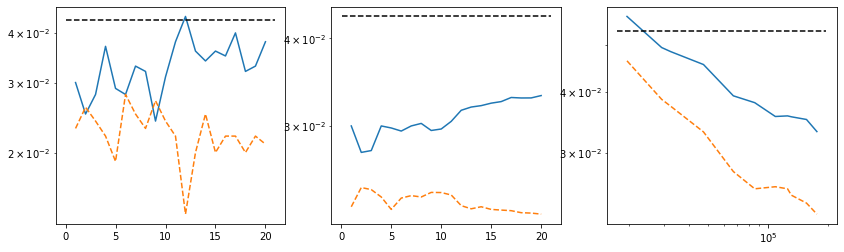

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

# Vector of number of shots
# NSVecIBM = np.arange(NS,NSTot+1,NS)
NSVecIBM = np.cumsum(shotVec)

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatTEP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatTRP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTEP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTRP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[2]
ax.plot(NSVecIBM, classMatTE ) 
ax.plot(NSVecIBM, classMatTR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatTE)
print(classMatTR)

plt.show()

#### Load saved IBMQ histograms for shuffle=0 disconnected chain <a id='disconn' />

<a href=#CA>Return to top of CA plot section</a>

In [ ]:
# Parameters

# Load compiled datasets
# Dictionary of bitstrings
bitstring_dict = []
calcString('', bitstring_dict, NR)

# Vector of runs
runVec = ['run01','run02','run03','run04','run05','run06','run07','run08','run09','run10']
# runVec = ['run01','run02','run03','run04','run05','run06','run07','run08','run09','run10','run11']
# runVec = ['run01','run02','run03']

# Vector of shots
# shotVec = int(2.5e4)*np.ones(len(runVec))
shotVec = [16125,25000,24875,11375,10750,10875,17125,24500,24750,24875]

# File name information
# fPreSave = '/Users/wewil/Documents/Postdoc/Workspace/StorageSpace/IBMQiskitRuntimeHistograms/'
fPreSave = '/scratch/gpfs/saeedk/IBMQiskitRuntimeHistograms/'
# exp_str = 'exper-T-02'
exp_str = 'exper-T-03'
    
# Complete data matrix
dataMatIBMRun = np.zeros((M,K,NL,len(runVec)))

# Iterate over messages
sT = time.time()

# Loop over datasets
for nr in range(len(runVec)):
    
    # Run string
    run_str = runVec[nr]

    # Number of shots
    NS = int( shotVec[nr] )
    
    # FIlename of file to load
    jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
    fileNameSave = f'{fPreSave}CEData/{exp_str}/{jbase}-hists'
                       
    # Load histogram of counts for this run 
    dataMatIBMRun[:,:,:,nr] = np.load(fileNameSave + '_NS_' + str(NS) + '.npy')

eT = time.time()
print('Extracted counts! Elapsed time: ' + str(eT-sT))

Extracted counts! Elapsed time: 0.11806249618530273


In [ ]:
# Counter for total number of shots
# NSTot = len(runVec)*NS
NSTot = np.cumsum(shotVec)[-1]

# Number of dataset permutations
# P = 1
# P = 10
P = 20

# Training and testing for each number of shots
classMatTRD = np.zeros((len(runVec)))
classMatTED = np.zeros((len(runVec)))  

# Training and testing for each number of shots per permutation
classMatTRDP = np.zeros((P,len(runVec)))
classMatTEDP = np.zeros((P,len(runVec)))  

# Initialize random number generator
np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    if p > 0:
        np.random.shuffle( randSort )
    
    # Data matrix for this permutation
    dataMatIBM = np.zeros((M,K,NL))
    
    # Loop over number of shots
    for nr in range(len(runVec)):

        # Data matrix for this run
        thisRunMat = np.copy(dataMatIBMRun[:,:,:,nr])
        
        # Shots
        NS = int( shotVec[nr] )

        # Compile full dataset over shots
        dataMatIBM[:,:,:] = dataMatIBM[:,:,:] + thisRunMat[randSort,:,:]
#         for k in range(K):
#             dataMatIBM[:,k,:] = dataMatIBM[:,k,:] + dataMatIBMRun[randSort,k,:,nr]

        # Sort symbols
        symbMatR = np.copy( symbMat )
        symbMatRR = symbMatR[randSort,:]
        
        # Normalize by dividing by number of shots
        dataMatIBM = dataMatIBM/NSTot

        # Compile training and testing sets
        train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data = np.transpose(dataMatIBM[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        MessageSetSymb_train = symbMatRR[0:50,:]
        MessageSetSymb_test = symbMatRR[50:,:]
        
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # Initialize logistic regression model
        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # Train model and then test using training set
        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
        CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Testing on testing set
        CAIBMTest = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    #     print('IBM Device CE error for NS: ' + str(NSTot))
        classMatTRDP[p,nr] = CAIBM
        classMatTEDP[p,nr] = CAIBMTest

        # Rescale counts
        dataMatIBM = dataMatIBM*NSTot
        
# Mean CA over permutations
classMatTRD = np.mean(classMatTRDP,axis=0)
classMatTED = np.mean(classMatTEDP,axis=0)

eT = time.time()
print('Calculated CA for IBMQ data with shuffle=0 and disconnected chain! Elapsed time: ' + str(eT-sT))

Calculated CA for IBMQ data with shuffle=0 and disconnected chain! Elapsed time: 8.979230403900146


[0.1879  0.1313  0.08605 0.0894  0.09125 0.09315 0.09335 0.10325 0.1093
 0.11045]
[0.1789  0.12    0.0702  0.07335 0.0761  0.0774  0.0771  0.08885 0.09595
 0.09625]


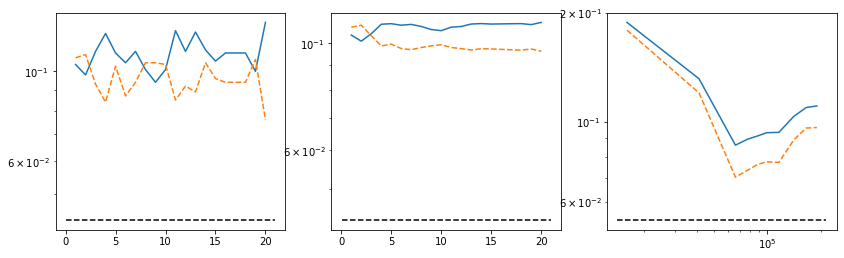

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

# Vector of number of shots
# NSVecIBM = np.arange(NS,NSTot+1,NS)
NSVecIBMD = np.cumsum(shotVec)

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatTEDP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatTRDP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTEDP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTRDP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[2]
ax.plot(NSVecIBMD, classMatTED ) 
ax.plot(NSVecIBMD, classMatTRD, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatTED)
print(classMatTRD)

plt.show()

#### Load saved IBMQ histograms for shuffle=0 connected chain without reset <a id='connnor' />

In [ ]:
# Parameters

# Load compiled datasets
# Dictionary of bitstrings
bitstring_dict = []
calcString('', bitstring_dict, NR)

# Vector of runs
# runVec = ['run01','run02']
# runVec = ['run01','run02','run03','run04','run05']
# runVec = ['run01','run02','run03','run04','run05','run06']
runVec = ['run01','run02','run03','run04','run05','run06','run07','run08']
# runVec = ['run01','run02','run03','run04','run05','run06','run07','run08','run09','run10','run11']
# runVec = ['run01','run02','run03','run04','run05','run06']

# Vector of shots
# shotVec = int(2.5e4)*np.ones(len(runVec))
shotVec = [25000,25000,25000,24875,24875,24875,24875,12750]

# File name information
# fPreSave = '/Users/wewil/Documents/Postdoc/Workspace/StorageSpace/IBMQiskitRuntimeHistograms/'
fPreSave = '/scratch/gpfs/saeedk/IBMQiskitRuntimeHistograms/'
# exp_str = 'exper-T-02'
# exp_str = 'exper-T-03'
exp_str = 'exper-T-05'
    
# Complete data matrix
dataMatIBMRun = np.zeros((M,K,NL,len(runVec)))

# Iterate over messages
sT = time.time()

# Loop over datasets
for nr in range(len(runVec)):
    
    # Run string
    run_str = runVec[nr]

    # Number of shots
    NS = int( shotVec[nr] )
    
    # FIlename of file to load
    jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
    fileNameSave = f'{fPreSave}CEData/{exp_str}/{jbase}-hists'
                       
    # Load histogram of counts for this run 
    dataMatIBMRun[:,:,:,nr] = np.load(fileNameSave + '_NS_' + str(NS) + '.npy')

eT = time.time()
print('Extracted counts! Elapsed time: ' + str(eT-sT))

Extracted counts! Elapsed time: 0.003829479217529297


In [ ]:
# Counter for total number of shots
# NSTot = len(runVec)*NS
NSTot = np.cumsum(shotVec)[-1]

# Number of dataset permutations
# P = 1
# P = 10
P = 20

# Training and testing for each number of shots
classMatTRNR = np.zeros((len(runVec)))
classMatTENR = np.zeros((len(runVec)))  

# Training and testing for each number of shots per permutation
classMatTRPNR = np.zeros((P,len(runVec)))
classMatTEPNR = np.zeros((P,len(runVec)))  

# Initialize random number generator
np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    if p > 0:
        np.random.shuffle( randSort )
    
    # Data matrix for this permutation
    dataMatIBM = np.zeros((M,K,NL))
    
    # Loop over number of shots
    for nr in range(len(runVec)):

        # Data matrix for this run
        thisRunMat = np.copy(dataMatIBMRun[:,:,:,nr])
        
        # Shots
        NS = int( shotVec[nr] )

        # Compile full dataset over shots
        dataMatIBM[:,:,:] = dataMatIBM[:,:,:] + thisRunMat[randSort,:,:]
#         for k in range(K):
#             dataMatIBM[:,k,:] = dataMatIBM[:,k,:] + dataMatIBMRun[randSort,k,:,nr]

        # Sort symbols
        symbMatR = np.copy( symbMat )
        symbMatRR = symbMatR[randSort,:]
        
        # Normalize by dividing by number of shots
        dataMatIBM = dataMatIBM/NSTot

        # Compile training and testing sets
        train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data = np.transpose(dataMatIBM[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        MessageSetSymb_train = symbMatRR[0:50,:]
        MessageSetSymb_test = symbMatRR[50:,:]
        
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # Initialize logistic regression model
        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # Train model and then test using training set
        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
        CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Testing on testing set
        CAIBMTest = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    #     print('IBM Device CE error for NS: ' + str(NSTot))
        classMatTRPNR[p,nr] = CAIBM
        classMatTEPNR[p,nr] = CAIBMTest

        # Rescale counts
        dataMatIBM = dataMatIBM*NSTot
        
# Mean CA over permutations
classMatTRNR = np.mean(classMatTRPNR,axis=0)
classMatTENR = np.mean(classMatTEPNR,axis=0)

eT = time.time()
print('Calculated CA for IBMQ data! Elapsed time: ' + str(eT-sT))

Calculated CA for IBMQ data! Elapsed time: 16.50183653831482


[0.46875 0.42825 0.388   0.37    0.36655 0.37665 0.37575 0.3741 ]
[0.43825 0.39305 0.3566  0.3393  0.3364  0.34115 0.3465  0.3497 ]


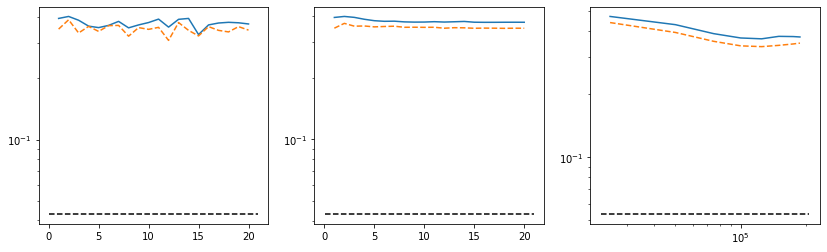

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

# Vector of number of shots
# NSVecIBM = np.arange(NS,NSTot+1,NS)
NSVecIBMNR = np.cumsum(shotVec)

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatTEPNR[:,-1])
ax.plot(np.arange(1,P+1,1), classMatTRPNR[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTEPNR[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTRPNR[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[2]
ax.plot(NSVecIBMNR, classMatTENR ) 
ax.plot(NSVecIBMNR, classMatTRNR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatTENR)
print(classMatTRNR)

plt.show()

#### Load saved Qiskit data - no loss <a id='simnoloss' />

<a href=#CA>Return to top of CA plot section</a>

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# cpname = 'red'
# CE task type
fT = ''

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97])/5 ).astype(int)*5 ).astype(int)

    
# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQTR = np.zeros((len(NSVec)))
classMatQTE = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQTRP = np.zeros((P,len(NSVec)))
classMatQTEP = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatz['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
        fName = 'Ansatz1_'
#         fName = 'Ansatz1_3_'
        for key in ansatz.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatz[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQTRP[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQTEP[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQTR = np.mean(classMatQTRP,axis=0)
classMatQTE = np.mean(classMatQTEP,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 14.079164743423462


[0.1633  0.07925 0.0525  0.0484  0.0483  0.04225 0.04095 0.0373  0.03615
 0.0365  0.03605 0.03165]
[0.14215 0.06095 0.0402  0.0336  0.03315 0.0263  0.02645 0.0237  0.02255
 0.0217  0.0212  0.01875]


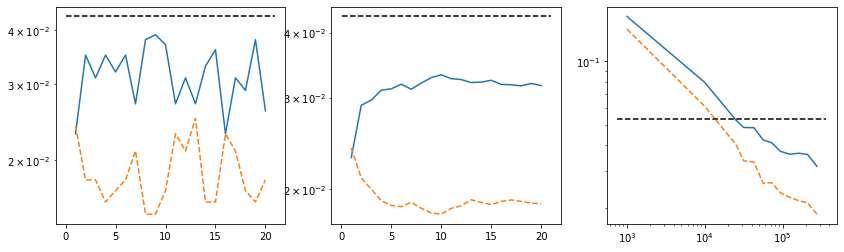

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQTEP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQTRP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQTEP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQTRP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQTE ) 
ax.plot(NSVec, classMatQTR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQTE)
print(classMatQTR)

plt.show()

#### Load saved Qiskit data - with losses and reset <a id='simloss' />

<a href=#CA>Return to top of CA plot section</a>

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# cpname = 'red'
# CE task type
fT = ''

# Decay parameters (microseconds)
T1m = 103e3
T1v = 10e3
T2m = 170e3
T2v = 10e3

# Reset parameter for loss ansatz
# resetLoss = 0
resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)

    
# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQLTR = np.zeros((len(NSVec)))
classMatQLTE = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQLTRP = np.zeros((P,len(NSVec)))
classMatQLTEP = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
#         fName = 'Ansatz1_'
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQLTRP[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQLTEP[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQLTR = np.mean(classMatQLTRP,axis=0)
classMatQLTE = np.mean(classMatQLTEP,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 12.478430271148682


[0.17195 0.07685 0.05495 0.0549  0.04525 0.04645 0.0435  0.03925 0.03655
 0.03725 0.0378 ]
[0.1467  0.0528  0.0377  0.03705 0.0342  0.03325 0.0275  0.0243  0.02295
 0.02315 0.0201 ]


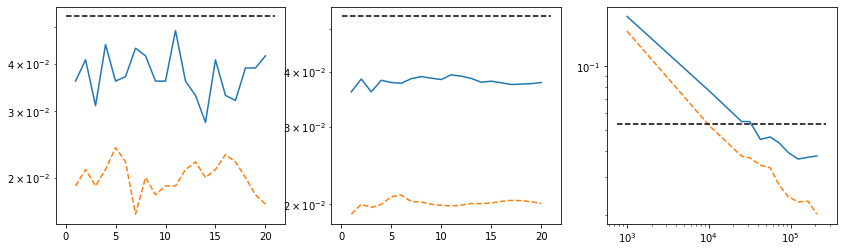

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQLTEP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQLTRP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTEP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTRP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQLTE ) 
ax.plot(NSVec, classMatQLTR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQLTE)
print(classMatQLTR)

plt.show()

#### Load saved Qiskit data - disconnected chain with losses <a id='simdisconnlosses' />

<a href=#CA>Return to top of CA plot section</a>

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
# cpname = 'lin'
# cpname = 'reduced'
cpname = 'reducedL'
# CE task type
fT = ''

# Decay parameters (microseconds)
T1m = 103e3
T1v = 10e3
T2m = 170e3
T2v = 10e3

# Reset parameter for loss ansatz
# resetLoss = 0
resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/5 ).astype(int)*5 ).astype(int)
    
# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQTRD = np.zeros((len(NSVec)))
classMatQTED = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQTRPD = np.zeros((P,len(NSVec)))
classMatQTEPD = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
#         fName = 'Ansatz1_'
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQTRPD[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQTEPD[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQTRD = np.mean(classMatQTRPD,axis=0)
classMatQTED = np.mean(classMatQTEPD,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 11.215075254440308


[0.1867  0.0912  0.06525 0.0616  0.06235 0.05815 0.05035 0.04995 0.0553
 0.0461 ]
[0.16255 0.07665 0.05255 0.04625 0.0495  0.04555 0.0412  0.0402  0.04355
 0.0361 ]


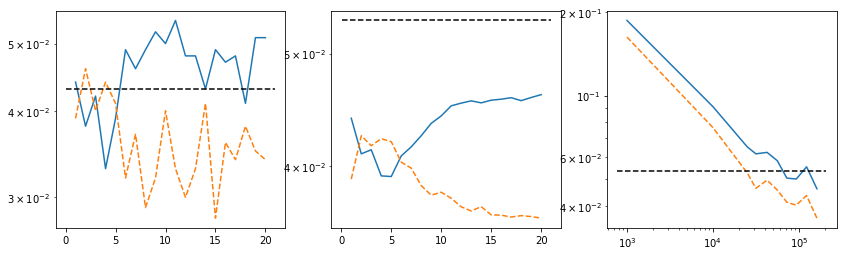

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQTEPD[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQTRPD[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [CAIn, CAIn], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQTEPD[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQTRPD[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQTED ) 
ax.plot(NSVec, classMatQTRD, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQTED)
print(classMatQTRD)

plt.show()

#### Load saved Qiskit data - No reset with losses <a id='simnoresetlosses' />

<a href=#CA>Return to top of CA plot section</a>

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# CE task type
fT = ''

# Decay parameters (microseconds)
T1m = 103e3
T1v = 10e3
T2m = 170e3
T2v = 10e3

# Reset parameter for loss ansatz
resetLoss = 0
# resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)

# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQNoResetTR = np.zeros((len(NSVec)))
classMatQNoResetTE = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQNoResetTRP = np.zeros((P,len(NSVec)))
classMatQNoResetTEP = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQNoResetTRP[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQNoResetTEP[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQNoResetTR = np.mean(classMatQNoResetTRP,axis=0)
classMatQNoResetTE = np.mean(classMatQNoResetTEP,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 9.787550687789917


[0.6466  0.59305 0.5763  0.56715 0.5648  0.56775 0.54765 0.54205 0.53845
 0.52665 0.5205 ]
[0.60235 0.5494  0.53605 0.5287  0.52475 0.528   0.5069  0.5022  0.4966
 0.497   0.4841 ]


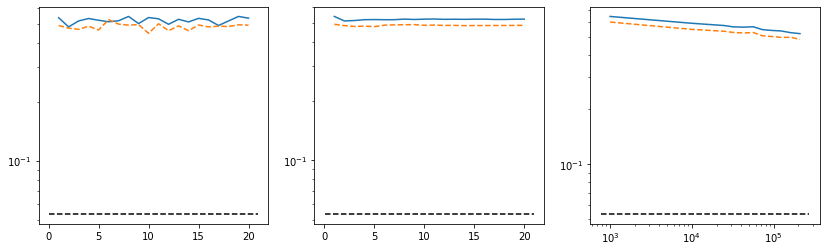

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQNoResetTEP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQNoResetTRP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQNoResetTEP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQNoResetTRP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQNoResetTE ) 
ax.plot(NSVec, classMatQNoResetTR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQNoResetTE)
print(classMatQNoResetTR)

plt.show()

### Classification accuracy plot <a id='finalplot' />

<a href=#CA>Return to top of CA plot section</a>

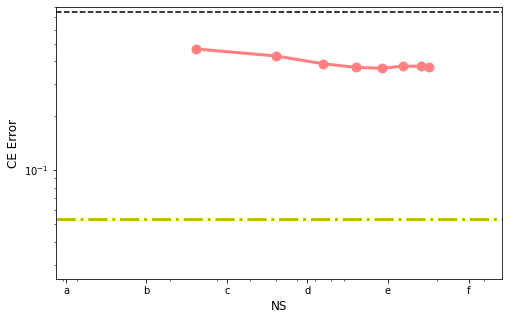

In [ ]:
# Plot classification accuracy
fig, ax = plt.subplots(1, 1, figsize=(8,5))
 
# ax.plot(NSVec, classMatTR, label='Training set')
# ax.scatter(NSVec, classMatTR)

# Colors
cg = ((119/255,136/255,153/255))
cbl=  ((0/255,51/255,128/255))
cbr=  ((140/255,86/255,75/255))
cp = ((255/255,128/255,128/255))
# cbll= ((119/255,136/255,153/255))
# cbrl= ((119/255,136/255,153/255))

############################################################################################

# Testing result using IBMQ

# # Connected chain with reset
# ax.plot(NSVecIBM, classMatTE, c=cbl, linewidth=4, label='Testing-IBMQ')
# ax.scatter(NSVecIBM, classMatTE, s=120, color=cbl)

# # Disconnected chain with reset
# ax.plot(NSVecIBMD, classMatTED, c=cbr, linewidth=3, label='Testing-IBMQ-disconnected')
# ax.scatter(NSVecIBMD, classMatTED, s=80, color=cbr)

# Connected chain without reset
ax.plot(NSVecIBMNR, classMatTENR, color=cp, linewidth=3, label='Testing-IBMQ-no reset')
ax.scatter(NSVecIBMNR, classMatTENR, s=80, color=cp)

############################################################################################

# # Testing result using Qiskit connected chain with reset and without losses
# NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
# ax.plot(NSVec[1:], classMatQTE[1:], c=cg, linewidth=2, zorder=-3, label='Testing-Qiskit')
# ax.scatter(NSVec[1:], classMatQTE[1:], s=60, color='w', edgecolor=cg)

# # Testing result using Qiskit connected chain with reset and with losses
# NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)
# ax.plot(NSVec[1:], classMatQLTE[1:], '--', color=cbl, alpha=0.5, linewidth=2, zorder=-3, label='Testing-Qiskit with losses')
# ax.scatter(NSVec[1:], classMatQLTE[1:], s=60, color='w', edgecolor=cbl)

# # Testing result using Qiskit disconnected chain with reset and with losses
# NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/5 ).astype(int)*5 ).astype(int)
# ax.plot(NSVec[1:], classMatQTED[1:], '--', color=cbr, alpha=0.5, linewidth=2, zorder=-3, label='Testing-Qiskit disconnected chain with losses')
# ax.scatter(NSVec[1:], classMatQTED[1:], s=60, color='w', edgecolor=cbr)

# # Testing result using Qiskit disconnected chain without reset and with losses
# NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)
# ax.plot(NSVec[1:], classMatQNoResetTE[1:], '--', color=cp, alpha=0.5, linewidth=2, zorder=-3, label='Testing-Qiskit connected chain with losses no reset')
# ax.scatter(NSVec[1:], classMatQNoResetTE[1:], s=60, color='w', edgecolor=cp)

############################################################################################

# ax.set_ylim([0.01,0.3])
# ax.set_ylim([0.01,0.8])
ax.set_ylim([0.025,0.8])
ax.set_xlim([7500,350000])

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
# ax.plot(xL,[CAIn,CAIn],'-k')
ax.plot(xL,[classMatInTE,classMatInTE], '-.', color=(191/255,191/255,0), linewidth=3, zorder=-3)
ax.plot(xL,[0.75,0.75],'--k')
# ax.legend()

# Plot testing accuracy
ax.set_xticks([2**13,2**14,2**15,2**16,2**17,2**18])
ax.set_xticklabels(['a','b','c','d','e','f'])

ax.set_ylabel('CE Error', fontsize=12)
ax.set_xlabel('NS', fontsize=12)

plt.show()

fig.savefig('CAVNS_IBM_2.pdf')

#### Load saved Qiskit data - Read out and reset all qubits

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# CE task type
fT = ''

# Decay parameters (microseconds)
T1m = 103e3
T1v = 10e3
T2m = 170e3
T2v = 10e3

# Reset parameter for loss ansatz
# resetLoss = 0
resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/5 ).astype(int)*5 ).astype(int)

# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQNoResetTR = np.zeros((len(NSVec)))
classMatQNoResetTE = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQNoResetTRP = np.zeros((P,len(NSVec)))
classMatQNoResetTEP = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQNoResetTRP[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQNoResetTEP[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQNoResetTR = np.mean(classMatQNoResetTRP,axis=0)
classMatQNoResetTE = np.mean(classMatQNoResetTEP,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 16.66835045814514


[0.08575 0.066   0.0602  0.05305 0.058   0.05495 0.0539  0.05335 0.0521
 0.0546 ]
[0.      0.0098  0.02095 0.022   0.0267  0.0305  0.0343  0.0376  0.0355
 0.03965]


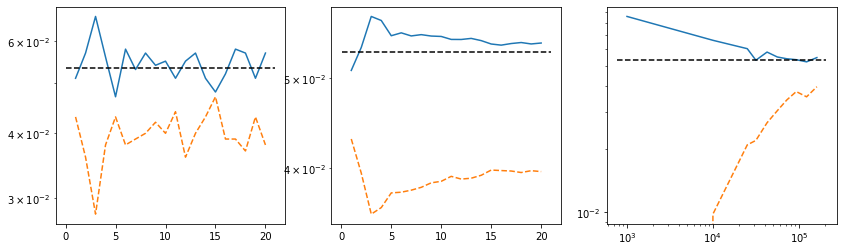

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQNoResetTEP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQNoResetTRP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQNoResetTEP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQNoResetTRP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQNoResetTE ) 
ax.plot(NSVec, classMatQNoResetTR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQNoResetTE)
print(classMatQNoResetTR)

plt.show()

### IBM Qiskit results with larger losses  <a id='CALoss' />

<a href=#top>Return to top</a>

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# cpname = 'red'
# CE task type
fT = ''

# Decay parameters (microseconds)
T1m = 103e3
T1v = 10e3
T2m = 170e3
T2v = 10e3

# Reset parameter for loss ansatz
# resetLoss = 0
resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)

    
# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQLTR = np.zeros((len(NSVec)))
classMatQLTE = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQLTRP = np.zeros((P,len(NSVec)))
classMatQLTEP = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
#         fName = 'Ansatz1_'
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQLTRP[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQLTEP[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQLTR = np.mean(classMatQLTRP,axis=0)
classMatQLTE = np.mean(classMatQLTEP,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 25.702252864837646


[0.171   0.0744  0.05325 0.0546  0.04715 0.04775 0.0428  0.03825 0.0345
 0.03585 0.03745]
[0.1461  0.05595 0.03915 0.0381  0.03215 0.032   0.0274  0.02345 0.0226
 0.02345 0.0212 ]


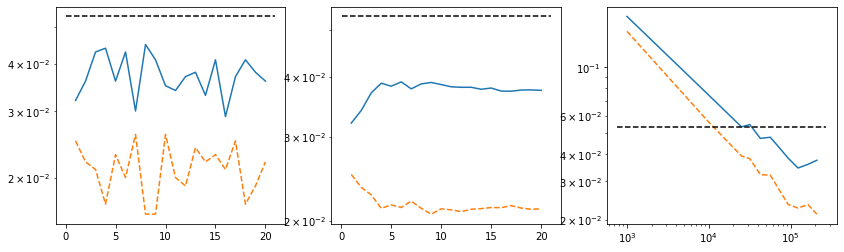

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQLTEP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQLTRP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTEP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTRP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQLTE ) 
ax.plot(NSVec, classMatQLTR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQLTE)
print(classMatQLTR)

plt.show()

#### Load saved Qiskit data - with factor 10 losses and reset

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# cpname = 'red'
# CE task type
fT = ''

# Decay parameters (microseconds)
# T1m = 1.03e3
# T1v = 0.10e3
# T2m = 1.70e3
# T2v = 0.10e3

T1m = 10.3e3
T1v = 1.0e3
T2m = 17.0e3
T2v = 1.0e3

# Reset parameter for loss ansatz
# resetLoss = 0
resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/5 ).astype(int)*5 ).astype(int)
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/10 ).astype(int)*10 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/10 ).astype(int)*10 ).astype(int)

    
# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQLTR2a = np.zeros((len(NSVec)))
classMatQLTE2a = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQLTRP2a = np.zeros((P,len(NSVec)))
classMatQLTEP2a = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
#         fName = 'Ansatz1_'
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQLTRP2a[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQLTEP2a[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQLTR2a = np.mean(classMatQLTRP2a,axis=0)
classMatQLTE2a = np.mean(classMatQLTEP2a,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 10.950907945632935


[0.1906  0.07665 0.06415 0.0492  0.0495  0.0427  0.04295 0.0409  0.0407
 0.0356  0.03655]
[0.1674  0.0577  0.0466  0.03585 0.0337  0.0302  0.02955 0.02685 0.02865
 0.0248  0.02535]


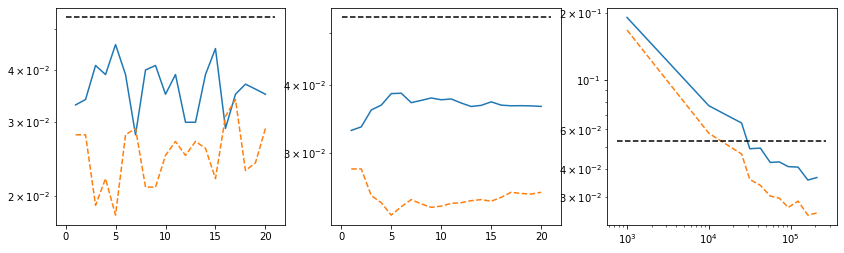

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQLTEP2a[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQLTRP2a[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTEP2a[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTRP2a[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQLTE2a ) 
ax.plot(NSVec, classMatQLTR2a, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQLTE2a)
print(classMatQLTR2a)

plt.show()

#### Load saved Qiskit data - with larger losses and reset

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# cpname = 'red'
# CE task type
fT = ''

# Decay parameters (microseconds)
# T1m = 1.03e3
# T1v = 0.10e3
# T2m = 1.70e3
# T2v = 0.10e3

T1m = 10.3e3
T1v = 1.0e3
T2m = 17.0e3
T2v = 1.0e3

# Reset parameter for loss ansatz
# resetLoss = 0
resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/10 ).astype(int)*10 ).astype(int)
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/10 ).astype(int)*10 ).astype(int)

    
# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQLTR2 = np.zeros((len(NSVec)))
classMatQLTE2 = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQLTRP2 = np.zeros((P,len(NSVec)))
classMatQLTEP2 = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
#         fName = 'Ansatz1_'
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQLTRP2[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQLTEP2[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQLTR2 = np.mean(classMatQLTRP2,axis=0)
classMatQLTE2 = np.mean(classMatQLTEP2,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gpfs/saeedk/NISQRC/CEData/Ansatz1_3_NQ_7_NR_4_NRIdx_[0, 2, 4, 6]_reset_1_NL_20_NT_3_thetaX_1.0_thetaZ_0.5_thetaI_0.1_J_1.0_sigmaX_1.0_sigmaZ_0.5_sigmaI_0.1_NS_208920_T1m_10300.0_T2m_17000.0_T1v_1000.0_T2v_1000.0_lin_CE_M_100_SNR_20.0_CN_8_seed_17462.npy'

[0.32155 0.13675 0.10045 0.0941  0.0908  0.09245 0.0838  0.0837  0.0808
 0.0765  0.0725 ]
[0.29615 0.1195  0.09015 0.0784  0.07875 0.07915 0.07135 0.07405 0.0699
 0.0697  0.06325]


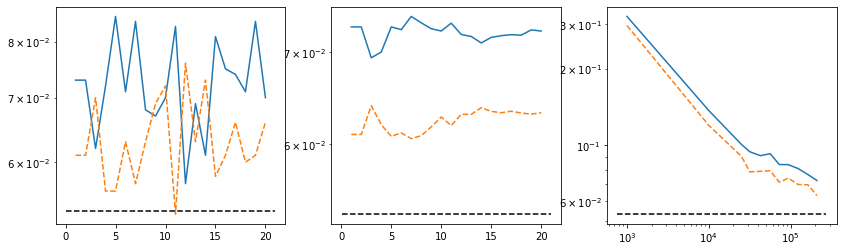

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQLTEP2[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQLTRP2[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTEP2[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTRP2[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQLTE2 ) 
ax.plot(NSVec, classMatQLTR2, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQLTE2)
print(classMatQLTR2)

plt.show()

#### Load saved Qiskit data - with largest losses and reset

In [ ]:
# Qiskit parameters
shufPar = 0
# shufPar = 1
cpname = 'lin'
# cpname = 'red'
# CE task type
fT = ''

# Decay parameters (microseconds)
T1m = 0.103e3
T1v = 0.010e3
T2m = 0.170e3
T2v = 0.010e3

# Reset parameter for loss ansatz
# resetLoss = 0
resetLoss = 1

# Define ansatz dictionary
ansatzLoss = {'NQ': NQ, 'NR': NR, 'NRIdx': NRIdx, 'reset': resetLoss, 'NL': NL, 'NT': NT, 'thetaX': thetaX, 'thetaZ': thetaZ, 'thetaI': thetaI, 'J': J, 'sigmaX': sigmaX, 'sigmaZ': sigmaZ, 'sigmaI': sigmaI, 'NS': NS, 'cp': coupling_map, 'T1m': T1m, 'T2m': T2m, 'T1v': T1v, 'T2v': T2v}
# print('Ansatz: ')
# print(ansatz)

# Vector of shots for NL = 100
if NL == 100:
    NSVec = [1e3, 1e4, 1e5]
    # NSVec = [1e3, 1e4]
    # NSVec = [1e3]

# Vector of shots for NL = 20
if NL == 20:
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32,5.44])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)
#     NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21])/5 ).astype(int)*5 ).astype(int)
    NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/10 ).astype(int)*10 ).astype(int)

    
# Directory name
fPre = '/scratch/gpfs/saeedk/NISQRC/CEData/'

# Number of dataset permutations
# P = 1
# P = 10
P = 20
# P = 50

# Training and testing for each number of shots
classMatQLTR3 = np.zeros((len(NSVec)))
classMatQLTE3 = np.zeros((len(NSVec)))  

# Training and testing for each number of shots per permutation
classMatQLTRP3 = np.zeros((P,len(NSVec)))
classMatQLTEP3 = np.zeros((P,len(NSVec)))  

# Initialize random number generator
# np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    np.random.shuffle( randSort )
#     if p > 0:
#         np.random.shuffle( randSort )
    
    # Loop over number of shots
    for n in range(len(NSVec)):

        # Update ansatz dictionary
        ansatzLoss['NS'] = int(NSVec[n])

        # Construct file name from circuit ansatz parameters
#         fName = 'Ansatz1_'
        fName = 'Ansatz1_3_'
        for key in ansatzLoss.keys():
            if key != 'cp':
                fName = fName + key + '_' + str(ansatzLoss[key]) + '_'

        # Coupling map style
        if shufPar == 0:
            fName = fName + cpname + '_'
        else:
            fName = fName + '_shuf_' + cpname + '_'

        # CE Task parameters
    #     fName = fName + 'CE_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)
        fName = fName + 'CE' + fT + '_M_' + str(M) + '_SNR_' + str(SNR) + '_CN_' + str(ccn) + '_seed_' + str(circSeed)

        # Load data
        dataMatQ = np.load(fPre + fName + '.npy')
        dataMat = dataMatQ[randSort,:,:]
        
        # Re-order symbols
        symbMatR = np.copy(symbMat)[randSort,:]

        # Perform classification
        train_data = np.transpose(dataMat[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data =  np.transpose(dataMat[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        MessageSetSymb_train = symbMatR[0:50,:]
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        MessageSetSymb_test = symbMatR[50:,:]
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = None, C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)

        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
#         CAMat[n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )
        classMatQLTRP3[p,n] = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Calculate testing accuracy
#         CATestMat[n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )
        classMatQLTEP3[p,n] = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    
# Mean CA over permutations
classMatQLTR3 = np.mean(classMatQLTRP3,axis=0)
classMatQLTE3 = np.mean(classMatQLTEP3,axis=0)

eT = time.time()
print('Calculated CA for Qiskit data! Elapsed time: ' + str(eT-sT))

Calculated CA for Qiskit data! Elapsed time: 1.6465699672698975


[0.76145 0.76145 0.76145 0.76145 0.76055 0.76145 0.76055 0.76055 0.76055
 0.76055 0.76145]
[0.73425 0.73425 0.73425 0.73425 0.73425 0.73425 0.73425 0.73425 0.73425
 0.73425 0.73425]


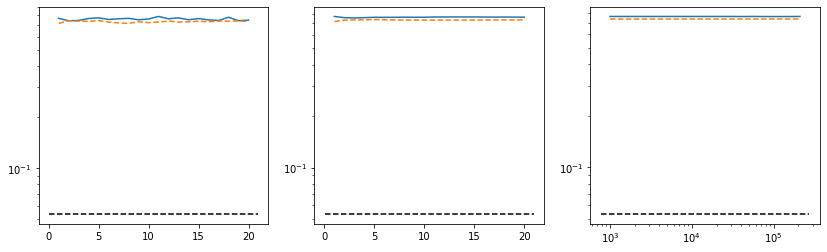

In [ ]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatQLTEP3[:,-1])
ax.plot(np.arange(1,P+1,1), classMatQLTRP3[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTEP3[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatQLTRP3[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVec, classMatQLTE3 ) 
ax.plot(NSVec, classMatQLTR3, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatQLTE3)
print(classMatQLTR3)

plt.show()

### Classification accuracy plot

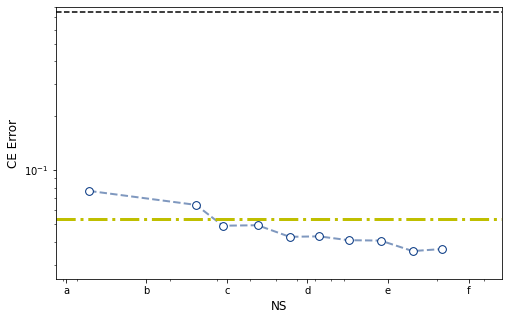

In [ ]:
# Plot classification accuracy
fig, ax = plt.subplots(1, 1, figsize=(8,5))
 
# ax.plot(NSVec, classMatTR, label='Training set')
# ax.scatter(NSVec, classMatTR)

# Colors
cg = ((119/255,136/255,153/255))
cbl=  ((0/255,51/255,128/255))
cbr=  ((140/255,86/255,75/255))
cp = ((255/255,128/255,128/255))
# cbll= ((119/255,136/255,153/255))
# cbrl= ((119/255,136/255,153/255))

############################################################################################

# # Testing result using Qiskit connected chain with reset and with lowest losses
# NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/5 ).astype(int)*5 ).astype(int)
# ax.plot(NSVec[1:], classMatQLTE[1:], '--', color=cbl, alpha=0.5, linewidth=2, zorder=-3, label='Testing-Qiskit with losses')
# ax.scatter(NSVec[1:], classMatQLTE[1:], s=60, color='w', edgecolor=cbl)

# Testing result using Qiskit connected chain with reset and with larger losses
NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/10 ).astype(int)*10 ).astype(int)
ax.plot(NSVec[1:], classMatQLTE2a[1:], '--', color=cbl, alpha=0.5, linewidth=2, zorder=-3, label='Testing-Qiskit with larger losses')
ax.scatter(NSVec[1:], classMatQLTE2a[1:], s=60, color='w', edgecolor=cbl)

# # Testing result using Qiskit connected chain with reset and with larger losses
# NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/10 ).astype(int)*10 ).astype(int)
# ax.plot(NSVec[1:], classMatQLTE2[1:], '--', color=cbl, alpha=0.5, linewidth=2, zorder=-3, label='Testing-Qiskit with larger losses')
# ax.scatter(NSVec[1:], classMatQLTE2[1:], s=60, color='w', edgecolor=cbl)

# # Testing result using Qiskit connected chain with reset and with largest losses
# NSVec = ( np.array( 10**np.array([3.0,4.0,4.4,4.5,4.63,4.75,4.86,4.97,5.09,5.21,5.32])/10 ).astype(int)*10 ).astype(int)
# ax.plot(NSVec[1:], classMatQLTE3[1:], '--', color=cbl, alpha=0.5, linewidth=2, zorder=-3, label='Testing-Qiskit with largest losses')
# ax.scatter(NSVec[1:], classMatQLTE3[1:], s=60, color='w', edgecolor=cbl)

############################################################################################

# ax.set_ylim([0.01,0.3])
# ax.set_ylim([0.01,0.8])
ax.set_ylim([0.025,0.8])
ax.set_xlim([7500,350000])

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
# ax.plot(xL,[CAIn,CAIn],'-k')
ax.plot(xL,[classMatInTE,classMatInTE], '-.', color=(191/255,191/255,0), linewidth=3, zorder=-3)
ax.plot(xL,[0.75,0.75],'--k')
# ax.legend()

# Plot testing accuracy
ax.set_xticks([2**13,2**14,2**15,2**16,2**17,2**18])
ax.set_xticklabels(['a','b','c','d','e','f'])

ax.set_ylabel('CE Error', fontsize=12)
ax.set_xlabel('NS', fontsize=12)

plt.show()

fig.savefig('CAVNS_IBM_Losses_Final.pdf')

#### IBMQ results with delays <a id='CADelay' />

<a href=#top>Return to top</a>

In [30]:
#### Load saved IBMQ histograms for shuffle=0 connected chain
# Parameters

# Load compiled datasets
# Dictionary of bitstrings
bitstring_dict = []
calcString('', bitstring_dict, NR)

# Vector of runs
# runVec = np.arange(0,5,1)
# runVec = np.arange(0,10,1)
runVec = np.arange(0,20,1)
# runVec = np.arange(0,1,1)

# Run string
# run_str = 'run01' # 20 us delay, original qubits
# run_str = 'run02'  # 20 us delay, new qubits
run_str = 'run03' # 40 us delay, original qubits
# run_str = 'run04' # 10 us delay, original qubits

# Vector of shots
shotVec = 25000*np.ones(len(runVec))
# shotVec = 24000*np.ones(len(runVec))

# shotVec = 250000*np.ones(len(runVec)) # Big batch file

# File name information
fPreSave = 'DellaBackup/scratch/gpfs/saeedk/IBMQiskitRuntimeHistograms/'
# exp_str = 'exper-T-02'
exp_str = 'exper-T-02-ext'
# exp_str = 'exper-T-03'
    
# Complete data matrix
dataMatIBMRun = np.zeros((M,K,NL,len(runVec)))

# Iterate over messages
sT = time.time()

# Loop over datasets
for nr in range(len(runVec)):
    
    # Number of shots
    NS = int( shotVec[nr] )
    
    # FIlename of file to load
    jbase = f"ce-{exp_str}-{run_str}-ibm_algiers"
    fileNameSave = f'{fPreSave}CEData/{exp_str}/{jbase}-hists'
                       
    # Load histogram of counts for this run 
    dataMatIBMRun[:,:,:,nr] = np.load(str('D:\\') + os.path.normpath(fileNameSave + '_NS_' + str(NS) + '_sH' + str(nr) + '.npy') )
    # dataMatIBMRun[:,:,:,nr] = np.load(str('D:\\') + os.path.normpath(fileNameSave + '_NS_' + str(NS) + '.npy') ) # Big batch file

eT = time.time()
print('Extracted counts! Elapsed time: ' + str(eT-sT))

Extracted counts! Elapsed time: 4.351545095443726


In [31]:
# Counter for total number of shots
# NSTot = len(runVec)*NS
NSTot = np.cumsum(shotVec)[-1]

# Number of dataset permutations
# P = 1
# P = 10
P = 20

# Training and testing for each number of shots
classMatTR = np.zeros((len(runVec)))
classMatTE = np.zeros((len(runVec)))  

# Training and testing for each number of shots per permutation
classMatTRP = np.zeros((P,len(runVec)))
classMatTEP = np.zeros((P,len(runVec)))  

# Initialize random number generator
np.random.seed(P)

# Loop over permutations
sT = time.time()
for p in range(P):
    
    # Random shuffling vector to extract pertinent training and testing datasets
    randSort = np.arange(0,M)
    if p > 0:
        np.random.shuffle( randSort )
    
    # Data matrix for this permutation
    dataMatIBM = np.zeros((M,K,NL))
    
    # Loop over number of shots
    for nr in range(len(runVec)):

        # Data matrix for this run
        thisRunMat = np.copy(dataMatIBMRun[:,:,:,nr])
        
        # Shots
        NS = int( shotVec[nr] )

        # Compile full dataset over shots
        dataMatIBM[:,:,:] = dataMatIBM[:,:,:] + thisRunMat[randSort,:,:]
#         for k in range(K):
#             dataMatIBM[:,k,:] = dataMatIBM[:,k,:] + dataMatIBMRun[randSort,k,:,nr]

        # Sort symbols
        symbMatR = np.copy( symbMat )
        symbMatRR = symbMatR[randSort,:]
        
        # Normalize by dividing by number of shots
        dataMatIBM = dataMatIBM/NSTot

        # Compile training and testing sets
        train_data = np.transpose(dataMatIBM[0:50,:,:], axes=[0,2,1]) # For LR on Qiskit output
        test_data = np.transpose(dataMatIBM[50:,:,:], axes=[0,2,1]) # For LR on Qiskit output
        MessageSetSymb_train = symbMatRR[0:50,:]
        MessageSetSymb_test = symbMatRR[50:,:]
        
        # train_data = inputMat[0:50,:] # For LR on data directly
        Output_Feature = train_data
        N_train = 50
        N_test = 50
        Nsymb = NL
        N_of = K

        Output_Feature_train = Output_Feature
        Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, N_of)) # For LR on Qiskit output
        # Output_Feature_train_stack = Output_Feature_train.reshape((N_train*Nsymb, 1)) # For LR on data directly 
        MessageSetSymb_train_stack = MessageSetSymb_train.reshape((N_train*Nsymb, 1))

        Output_Feature_test = test_data
        Output_Feature_test_stack = Output_Feature_test.reshape((N_test*Nsymb, N_of)) # For LR on Qiskit output
        MessageSetSymb_test_stack = MessageSetSymb_test.reshape((N_test*Nsymb, 1))

        # Initialize logistic regression model
        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e7, max_iter=500)
        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e6, max_iter=500)
        lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e5, max_iter=500)
        # lr = linear_model.LogisticRegression(fit_intercept=True, solver = 'newton-cg', penalty = 'l2', C=1e4, max_iter=500)

        # Train model and then test using training set
        # lr = linear_model.LogisticRegression(fit_intercept=False, solver = 'newton-cg', penalty = 'none', max_iter=500)
        lr.fit(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0])
        CAIBM = 1-( lr.score(Output_Feature_train_stack, MessageSetSymb_train_stack.T[0]) )

        # Testing on testing set
        CAIBMTest = 1-( lr.score(Output_Feature_test_stack, MessageSetSymb_test_stack.T[0]) )

    #     print('IBM Device CE error for NS: ' + str(NSTot))
        classMatTRP[p,nr] = CAIBM
        classMatTEP[p,nr] = CAIBMTest

        # Rescale counts
        dataMatIBM = dataMatIBM*NSTot
        
# Mean CA over permutations
classMatTR = np.mean(classMatTRP,axis=0)
classMatTE = np.mean(classMatTEP,axis=0)

eT = time.time()
print('Calculated CA for IBMQ data! Elapsed time: ' + str(eT-sT))


Calculated CA for IBMQ data! Elapsed time: 16.02333950996399


In [18]:
classMatTE, classMatTR

(array([0.04865]), array([0.03115]))

[0.1208  0.09615 0.0941  0.08305 0.07195 0.0662  0.0621  0.0629  0.0564
 0.05605 0.06165 0.05885 0.0589  0.05565 0.0512  0.0493  0.04645 0.0445
 0.0436  0.04135]
[0.10855 0.0863  0.08265 0.0708  0.0621  0.0568  0.05055 0.0497  0.04575
 0.04615 0.051   0.04675 0.04545 0.0425  0.03835 0.0358  0.03375 0.03295
 0.031   0.0295 ]


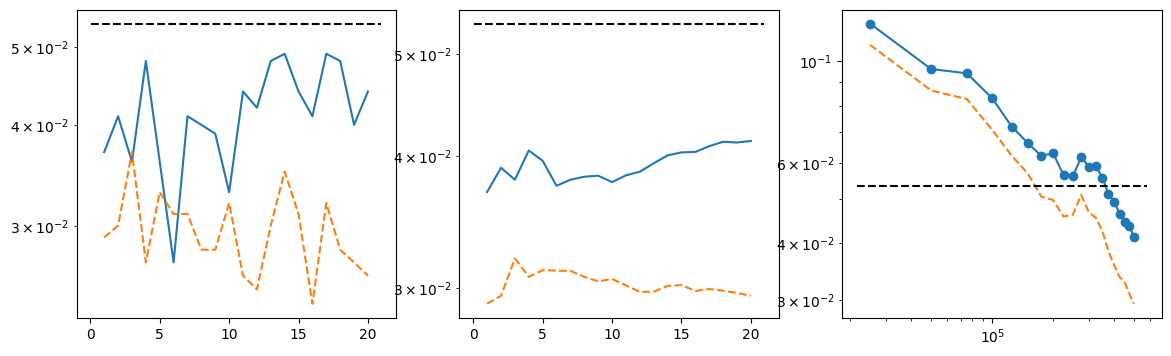

In [32]:
# Performance vs. P
fig, axs = plt.subplots(1, 3, figsize=(14,4))

# Vector of number of shots
# NSVecIBM = np.arange(NS,NSTot+1,NS)
NSVecIBM = np.cumsum(shotVec)

ax = axs[0]
ax.plot(np.arange(1,P+1,1), classMatTEP[:,-1])
ax.plot(np.arange(1,P+1,1), classMatTRP[:,-1], '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[1]
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTEP[:,-1])/np.arange(1,P+1,1) ) 
ax.plot(np.arange(1,P+1,1), np.cumsum(classMatTRP[:,-1])/np.arange(1,P+1,1), '--')

ax.set_yscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

ax = axs[2]
ax.plot(NSVecIBM, classMatTE )
ax.scatter(NSVecIBM, classMatTE ) 
ax.plot(NSVecIBM, classMatTR, '--')

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
ax.plot(xL, [classMatInTE, classMatInTE], '--k')

print(classMatTE)
print(classMatTR)

plt.show()

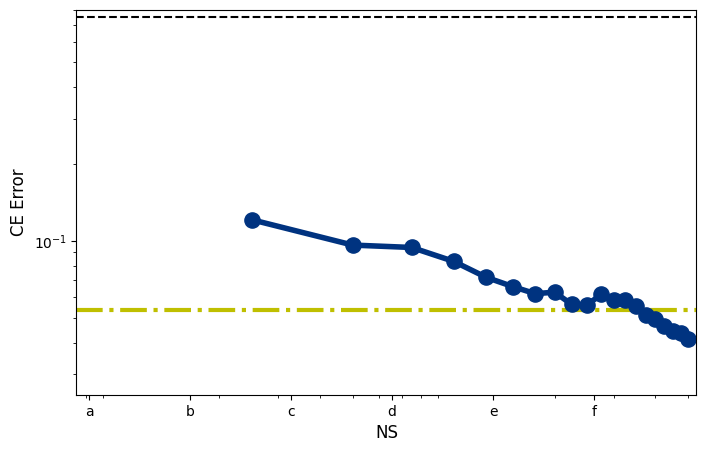

In [35]:
# Plot classification accuracy
fig, ax = plt.subplots(1, 1, figsize=(8,5))
 
# ax.plot(NSVec, classMatTR, label='Training set')
# ax.scatter(NSVec, classMatTR)

# Colors
cg = ((119/255,136/255,153/255))
cbl=  ((0/255,51/255,128/255))
cbr=  ((140/255,86/255,75/255))
cp = ((255/255,128/255,128/255))
# cbll= ((119/255,136/255,153/255))
# cbrl= ((119/255,136/255,153/255))

############################################################################################

# Connected chain with reset
ax.plot(NSVecIBM, classMatTE, c=cbl, linewidth=4, label='Testing-IBMQ')
ax.scatter(NSVecIBM, classMatTE, s=120, color=cbl)

############################################################################################

# ax.set_ylim([0.01,0.3])
# ax.set_ylim([0.01,0.8])
ax.set_ylim([0.025,0.8])
# ax.set_xlim([7500,350000])
ax.set_xlim([7500,530000])

ax.set_yscale('log')
ax.set_xscale('log')
xL = ax.get_xlim()
# ax.plot(xL,[CAIn,CAIn],'-k')
ax.plot(xL,[classMatInTE,classMatInTE], '-.', color=(191/255,191/255,0), linewidth=3, zorder=-3)
ax.plot(xL,[0.75,0.75],'--k')
# ax.legend()

# Plot testing accuracy
ax.set_xticks([2**13,2**14,2**15,2**16,2**17,2**18])
ax.set_xticklabels(['a','b','c','d','e','f'])

ax.set_ylabel('CE Error', fontsize=12)
ax.set_xlabel('NS', fontsize=12)

plt.show()

fig.savefig('CAVNS_IBM_Delay.pdf')